## Active Learning

Download the titanic dataset here: https://drive.google.com/file/d/0Bz9_0VdXvv9bbVhpOEMwUDJ2elU/view?usp=sharing

In this exercise, we will simulate active learning. We will keep the small sample of observations for testing and we will test how quality of the model rises when we use active learning to choose labeled observations.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report

import copy

#configure visualization
%matplotlib inline
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 8,6

In [2]:
# Load the Train Data
train = pd.read_csv('titanic/train.csv')
print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

### EDA 

In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


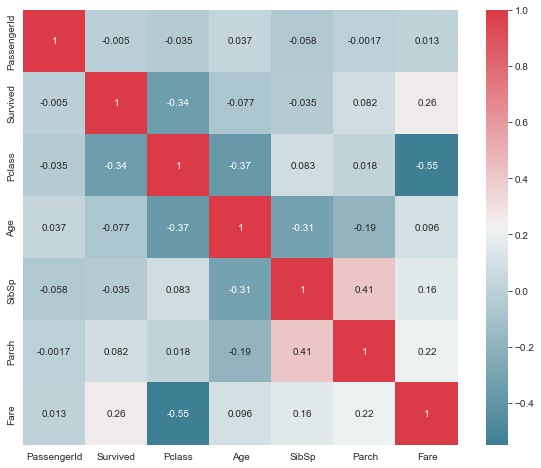

In [5]:
#plot heat map
corr = train.corr()

plt.figure(figsize=(10,8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, square=True, annot=True)


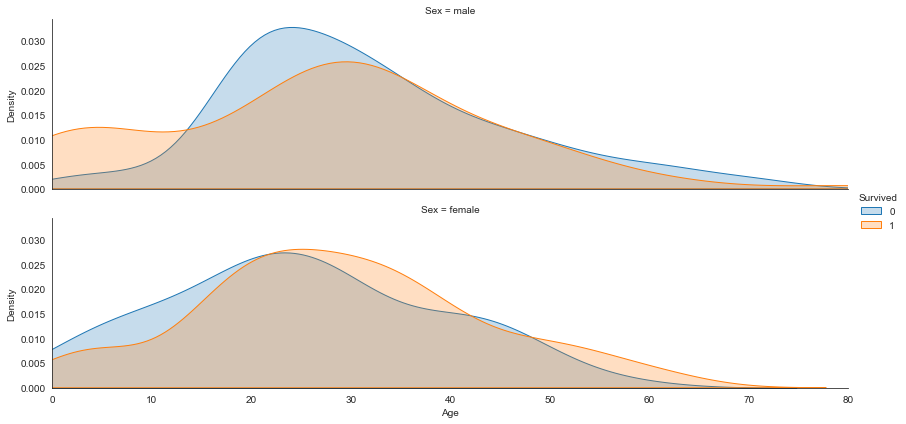

In [6]:
#Relationship between age and survival
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

plot_distribution(train, var = 'Age', target = 'Survived', row = 'Sex')

/opt/anaconda3/envs/LHLBootcamp/lib/python3.6/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


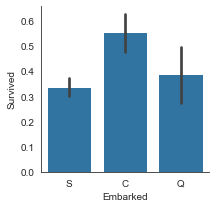

In [7]:
#Plot number of embarked
def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

plot_categories(train, cat ='Embarked', target='Survived')

/opt/anaconda3/envs/LHLBootcamp/lib/python3.6/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


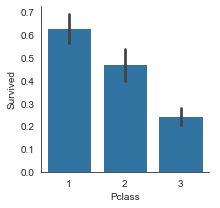

In [8]:
#plot cabins
plot_categories(train, cat ='Pclass', target='Survived')

/opt/anaconda3/envs/LHLBootcamp/lib/python3.6/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


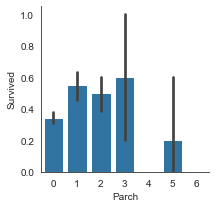

In [9]:
#plot by parch
plot_categories(train, cat ='Parch', target='Survived')

/opt/anaconda3/envs/LHLBootcamp/lib/python3.6/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


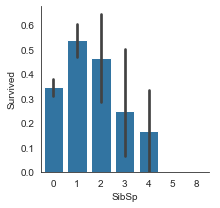

In [10]:
#plot sib sp
plot_categories(train, cat ='SibSp', target='Survived')

/opt/anaconda3/envs/LHLBootcamp/lib/python3.6/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


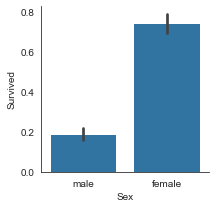

In [11]:
#plot sex
plot_categories(train, cat ='Sex', target='Survived')

### Preprocessing

In [12]:
#check null values
train.isnull().sum() * 100 / len(train)

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [13]:
#create copy
new_train = copy.deepcopy(train)

#drop columns
new_train = new_train.drop(['Name', 'Ticket', 'Cabin'], axis = 1)

#replace null Age values with mean
new_train['Age'] = new_train['Age'].fillna(value=new_train['Age'].mean())

#replace null embarked values with S (most common) - (this applies to all columns but only embarked has missing values)
new_train = new_train.apply(lambda x: x.fillna(x.value_counts().index[0]))

#Check null values
new_train.isnull().sum() * 100 / len(new_train)

PassengerId    0.0
Survived       0.0
Pclass         0.0
Sex            0.0
Age            0.0
SibSp          0.0
Parch          0.0
Fare           0.0
Embarked       0.0
dtype: float64

In [14]:
new_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [15]:
#insert ordinal numbers
new_train.Embarked = new_train.Embarked.map({'S':0,'C':1,'Q':2})
new_train.Sex = new_train.Sex.map({'female':0, 'male': 1})


In [16]:
#name categorical columns
cat_col = ['Pclass','Sex','SibSp','Parch','Embarked']

#Get dummies of categorical columns
new_train = pd.get_dummies(data=new_train, columns=cat_col)

#view new table
new_train.head()

,PassengerId,Survived,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,SibSp_0,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_0,Embarked_1,Embarked_2
0,1,0,22.0,7.2500,0,0,1,0,1,0,...,1,0,0,0,0,0,0,1,0,0
1,2,1,38.0,71.2833,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
2,3,1,26.0,7.9250,0,0,1,1,0,1,...,1,0,0,0,0,0,0,1,0,0
3,4,1,35.0,53.1000,1,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
4,5,0,35.0,8.0500,0,0,1,0,1,1,...,1,0,0,0,0,0,0,1,0,0


## Split up data

In [17]:
# TEST SAMPLE
print(new_train.shape)

# USE THIS SAMPLE ONLY FOR TESTING
test_df = new_train.sample(n=100, random_state=72)
print(test_df.shape)

# KEEP ONLY THOSE WHO ARE NOT IN THE TEST SET
new_train = new_train[~new_train.PassengerId.isin(test_df.PassengerId.tolist())]
print(new_train.shape)

(891, 26)
(100, 26)
(791, 26)


In [18]:
# FIT THE FIRST MODEL ONLY ON THE DATAFRAME START_DF
start_df = new_train.sample(n=100, random_state=42)
print(start_df.shape)

# DROP OBS FROM START_DF FROM DF
df = new_train[~new_train.PassengerId.isin(start_df.PassengerId.tolist())]
print(df.shape)

(100, 26)
(691, 26)


### Tasks

1. fit the first model only on the **start_df** using **SVM** and evaluate accuracy, precision and recall on test_df
2. in each iteration, add 10 observations from **df** to your trainset (choose the observation using active learning approach) 
    - score all observations in df and take 10 where the model isn't sure what class it is. The probability of surviving will be around 50% 
3. refit the model and evaluate on **test_df** again.    
3. the goal is to converge to the optimal solution as fast as possible by choosing **right** observations in each iteration
4. plot the graphs for each eval metric, where on the axis x is iteration number, on y is the metric value for that model

In [19]:
X = start_df.drop(['Survived', 'PassengerId'], axis = 1)
y = start_df.Survived

#instantiate and fit classifier
svc = svm.SVC(probability = True, random_state =123)
svc.fit(X, y)

SVC(probability=True, random_state=123)

In [20]:
#Predict test_df
y_predict = svc.predict(test_df.drop(['Survived', 'PassengerId'], axis = 1))

#Check metrics
print("Confusion Matrix\n", confusion_matrix(y,y_predict))

print("Accuracy:", accuracy_score(y,y_predict))

print("Roc Score:", roc_auc_score(y, svc.predict_proba(test_df.drop(['Survived', 'PassengerId'], axis = 1))[:,1]))

Confusion Matrix
 [[42 14]
 [38  6]]
Accuracy: 0.48
Roc Score: 0.4908685064935065


In [21]:
#print classification report
print(classification_report(y,y_predict))

              precision    recall  f1-score   support

           0       0.53      0.75      0.62        56
           1       0.30      0.14      0.19        44

    accuracy                           0.48       100
   macro avg       0.41      0.44      0.40       100
weighted avg       0.43      0.48      0.43       100



### iteration

In [33]:
#copy start_df and df
start_df_2 = copy.deepcopy(start_df)
df_2 = copy.deepcopy(df)

#create empty list for iteration
iteration = []

#create empty list for accuracy
accuracy = []

y_test = test_df.Survived

#Create for loop to go through
for i in range(15):
    
    # get 10 random samples
    rand_sample = df_2.sample(n=10, replace = False)

    #remove the 10 random samples from new_df
    df_2 = df_2[~df_2.PassengerId.isin(rand_sample.PassengerId.tolist())]

    #Add to start_df_2 into new variable
    start_df_2 = pd.concat([start_df_2, rand_sample])

#     print shape
#     print(start_df_2.shape)
#     print(df_2.shape)

    #reset index, remove empty values
    start_df_2 = start_df_2[~start_df_2.isin([np.nan, np.inf, -np.inf]).any(1)]
    
    #split into X and Y
    y = start_df_2.pop('Survived')
    X = start_df_2.drop('PassengerId', axis = 1)
    
    #instantiate and fit classifier
    model = svm.SVC(probability = True, random_state =52)
    
    #fit model
    fit_model = model.fit(X, y)

    #Predict test_df
    y_pred = fit_model.predict(test_df.drop(['Survived', 'PassengerId'], axis = 1))
    
    #print accuracy
    score = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy {i}:", score) 
    
    #y.sample(n=100, replace = True)
    
    #append iterations and scores to lists
    iteration.append(i)
    accuracy.append(score)

Model Accuracy 0: 0.66
Model Accuracy 1: 0.57
Model Accuracy 2: 0.57
Model Accuracy 3: 0.69
Model Accuracy 4: 0.55
Model Accuracy 5: 0.6
Model Accuracy 6: 0.61
Model Accuracy 7: 0.61
Model Accuracy 8: 0.59
Model Accuracy 9: 0.57
Model Accuracy 10: 0.57
Model Accuracy 11: 0.59
Model Accuracy 12: 0.58
Model Accuracy 13: 0.63
Model Accuracy 14: 0.65


In [34]:
#create empty dataframe
iterated_acc = pd.DataFrame()

#add iterations and accuracy lists as columns
iterated_acc['No. Iterations'] = iteration
iterated_acc['Accuracy %'] = accuracy

#View new dataframe
iterated_acc.head()

,No. Iterations,Accuracy %
0,0,0.66
1,1,0.57
2,2,0.57
3,3,0.69
4,4,0.55


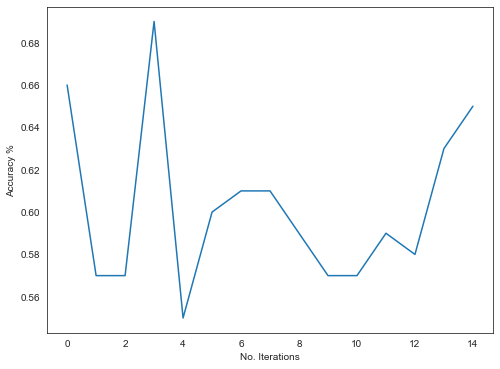

In [35]:
#View Accuracy over iterations
sns.lineplot(data=iterated_acc, x='No. Iterations', y='Accuracy %')